## Let's automate feature discovery

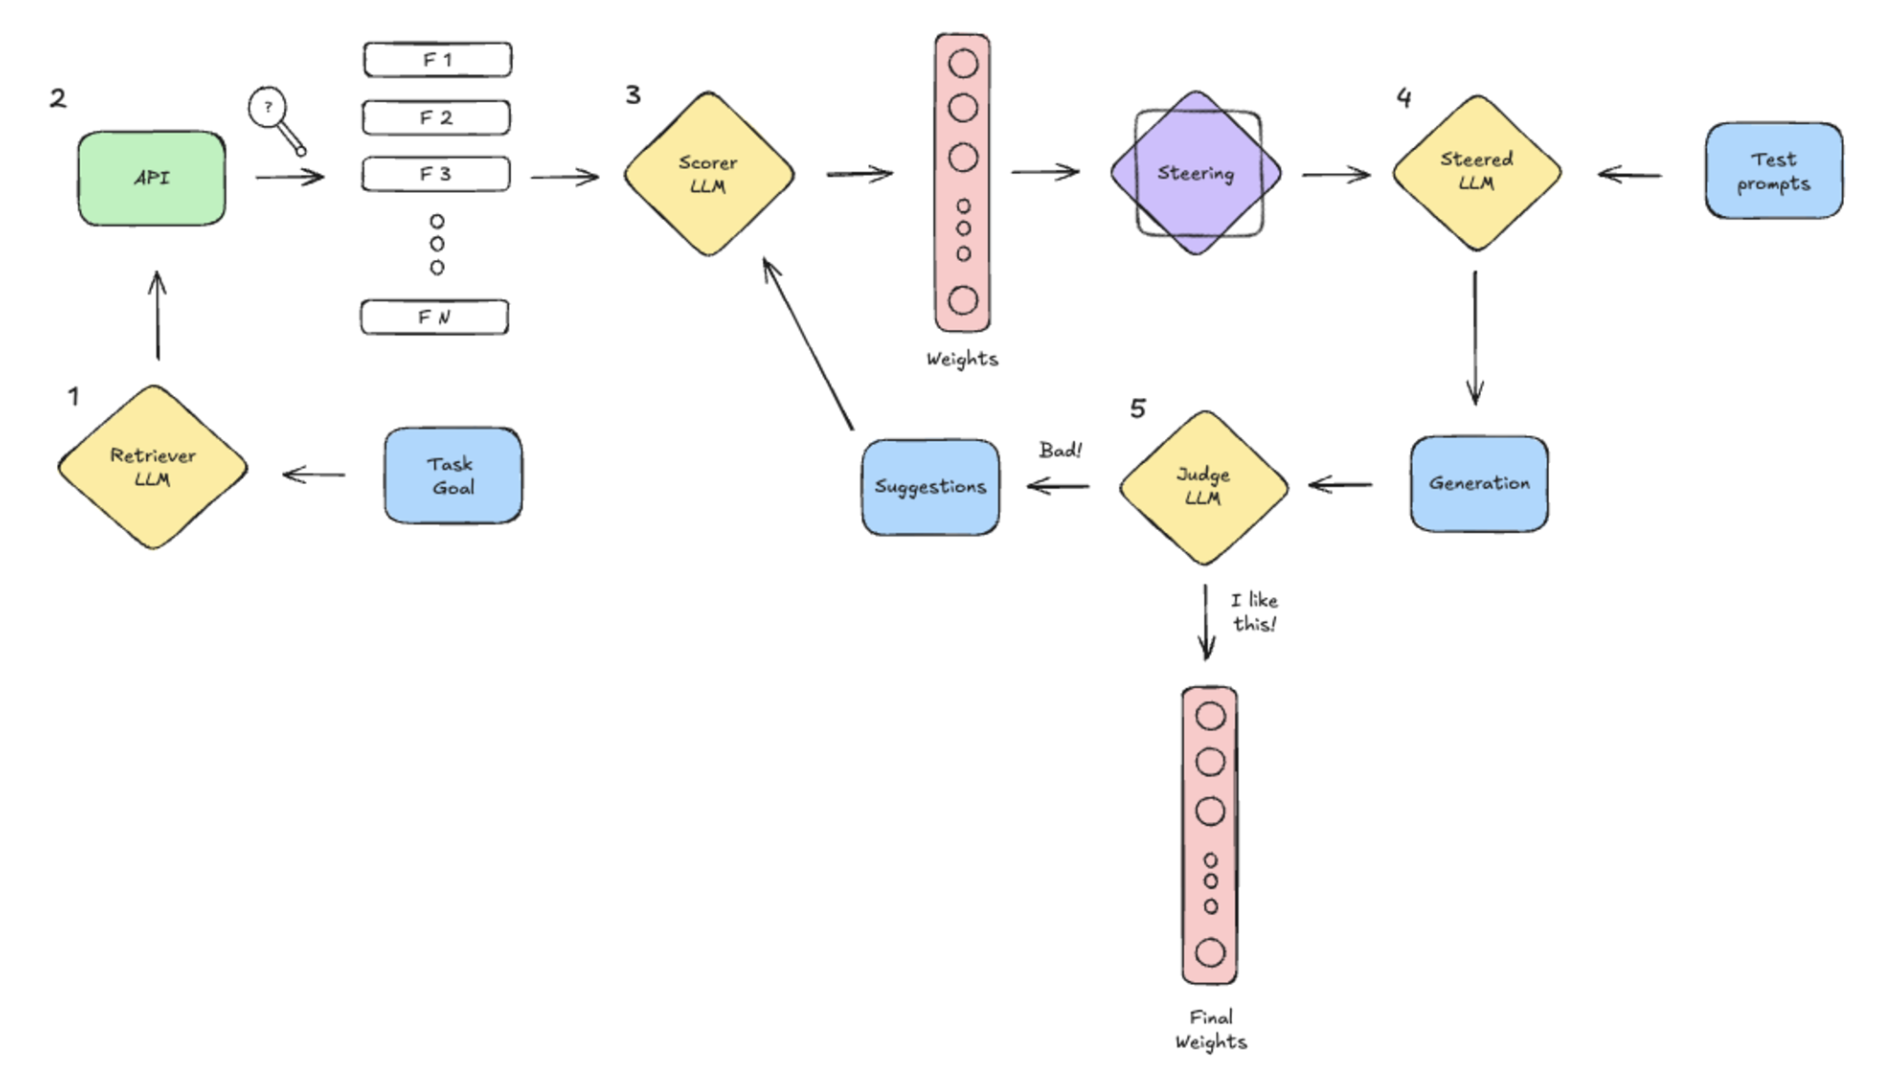

**FEATURE RETRIEVER:** from a prompt you have a set of relevant features to steer that are the output
**FEATURE MODIFIER:** given a set of features and a set of feedback - that can also be empty for the first iteration - steer the features in the right directions
**FEATURE JUDGER** from a test model get


## setup stuff

In [23]:
!pip install goodfire

In [24]:
from google.colab import userdata
GOODFIRE_API_KEY = userdata.get('GOODFIRE_API_KEY')

import goodfire

client = goodfire.Client(
    GOODFIRE_API_KEY
  )

# Instantiate a model variant
variant = goodfire.Variant("meta-llama/Meta-Llama-3-8B-Instruct")

In [25]:
for token in client.chat.completions.create(
    [
        {"role": "user", "content": "hi, what is going on?"}
    ],
    model=variant,
    stream=True,
    max_completion_tokens=50,
):
    print(token.choices[0].delta.content, end="")

Hello there! Not much is going on, just waiting to help you with whatever you need. How about you? What's on your mind today?

# RETRIEVER 🦮
## from a prompt you have as output the set of relevant features

In [27]:
# prompt

In [28]:
pirate_features, relevance = client.features.search(
    "pirate",
    model=variant,
    top_k=5
)
pirate_features

FeatureGroup([
   0: "Pirate-related language and themes",
   1: "Pirate characters and themes in fiction and role-playing games",
   2: "The model should roleplay as a pirate",
   3: "Mischievous behavior and troublemaking",
   4: "Mentions of rum, especially in pirate or cocktail contexts"
])

In [29]:
picked_pirate_feature = pirate_features[0]
picked_pirate_feature

Feature("Pirate-related language and themes")

In [30]:
picked_pirate_feature.index_in_sae
picked_pirate_feature.uuid

UUID('9b2e0cee-66ef-44e7-9b33-750c820b814c')

Score

# Score


In [31]:
import goodfire

client = goodfire.Client(
    GOODFIRE_API_KEY
  )

# get 70B model
scoreLLM = goodfire.Variant("meta-llama/Meta-Llama-3.1-70B-Instruct")

In [32]:
print(str(pirate_features))

FeatureGroup([
   0: "Pirate-related language and themes",
   1: "Pirate characters and themes in fiction and role-playing games",
   2: "The model should roleplay as a pirate",
   3: "Mischievous behavior and troublemaking",
   4: "Mentions of rum, especially in pirate or cocktail contexts"
])


In [33]:
scorer_LLM = goodfire.Variant("meta-llama/Meta-Llama-3.1-70B-Instruct")

In [34]:
for token in client.chat.completions.create(
    [
        {"role": "user", "content": "User: given a list of features, please respond with a list of scores between -1 and 1, an example input is "+
        'FeatureGroup([\
   0: "The user is directing the model to modify or transform content",\
   1: "The model is being instructed how to answer",], an example output is [0.3, -0.7, 0.5]. Here\'s the features: ' + f"{str(pirate_features)}"}
    ],
    model=variant,
    stream=True,
    max_completion_tokens=250,
):
    print(token.choices[0].delta.content, end="")

I'd be happy to help you with that. Here's the list of scores based on the given features:

[-0.1, 0.4, 0.8, 0.2, 0.6]

Let me know if you need any further assistance!

In [35]:
import re

text = "I'd be happy to help you with that. Here's the list of scores based on the given features: [-0.1, 0.4, 0.8, 0.2, 0.6] Let me know if you need any further assistance!"

# Method 1: Using regex to find all numbers including negatives and decimals
numbers = re.findall(r'-?\d*\.?\d+', text)
numbers = [float(x) for x in numbers]  # Convert strings to floats
print(numbers)  # [-0.1, 0.4, 0.8, 0.2, 0.6]


[-0.1, 0.4, 0.8, 0.2, 0.6]


In [43]:
assert(len(numbers) == len(pirate_features))

# Steered LLM

In [36]:
steeredLLM = goodfire.Variant("meta-llama/Meta-Llama-3.1-70B-Instruct")

In [37]:
for feature, score in zip(pirate_features, numbers):
    steeredLLM.set(feature, score)

In [38]:
questions_dict = {
    "1.COUNTING AND NUMERICAL SEQUENCES": [
        "How many letters are there in 'Mississippi River' excluding spaces?",
        "How many words in this text contain double letters?",
        "Count all instances of the word 'the' in this paragraph, including variations like 'they' and 'them'",
        "What is the next number in the sequence: 1, 1, 2, 3, 5, 8, 13, _?",
        "In a string of 100 alternating letters 'ABABAB...', what's the 97th letter?",
        "How many triangles are in this overlapping geometric figure?",
        "Count the total number of closed loops in this paragraph (letters like 'o', 'p', 'b', etc.)",
        "What's the sum of all two-digit numbers that appear in this text?",
        "How many unique characters are in this Unicode string?",
        "Count how many times 'ing' appears within other words in this paragraph"
    ],
    "2.TEMPORAL REASONING": [
        "If I start a 48-hour task at 9:30 PM on Thursday, when will it end?",
        "How many Tuesdays are there between March 15 and June 22?",
        "If it's 3 PM in Tokyo, what time is it in New York during daylight savings time?",
        "What day of the week was July 4th, 1776?",
        "If I fly from Sydney to Los Angeles, leaving on Monday at 11 PM and flying for 13 hours, what day and time do I arrive?",
        "How many days are between December 31, 1999, and January 2, 2000?",
        "If Event A happens every 3 days and Event B every 4 days, when is the next time they coincide?",
        "In what year will March 1st fall on a Sunday three times?",
        "What's the duration between 11:45 PM and 12:30 AM the next day?",
        "How many leap years occurred between 1900 and 2000?"
    ],
    "3.LOGICAL/CONSTRAINT PUZZLES": [
        "In a room of 4 people, each person shakes hands with everyone else once. How many handshakes occur?",
        "If all Bloops are Gleeps, and some Gleeps are Floops, are all Bloops definitely Floops?",
        "In a race, Tom finished ahead of Bob but behind Sue. If Mary beat Sue, who came in last?",
        "If no A is B, and all B is C, what can we conclude about A and C?",
        "On an island, knights always tell truth and knaves always lie. Someone says 'I am a knave.' What are they?",
        "If Red is taller than Blue, Blue is shorter than Green, and Yellow is taller than Red, who is tallest?",
        "In a line of 5 colored boxes, red cannot be next to blue, green must be between yellow and blue. What's a possible arrangement?",
        "If book A must be read before book B, and book C must be read after book B but before book D, what's the earliest position for book C?",
        "In a group of 3 friends, each has a unique favorite color among red, blue, and green. If John doesn't like blue, and Mary's favorite isn't green, what's Tom's favorite?",
        "If every student speaks at least two languages, and there are only three languages taught, prove some language must be spoken by at least two students"
    ],
    "4.MULTI-STEP MATH": [
        "A train travels 120 km at 60 km/h, then 80 km at 40 km/h. What's the average speed?",
        "If a phone's price increases 20% then decreases 20%, what's the final percentage change?",
        "A rope is cut into three pieces. The second piece is twice as long as the first, and the third is 3m longer than the second. If the total length is 27m, how long is each piece?",
        "In a tank filling problem, pipe A fills at 10 L/min, pipe B at 15 L/min, and pipe C drains at 5 L/min. If the tank holds 200 L, how long to fill?",
        "If 6 workers take 7 days to build a wall, how many days would 9 workers take?",
        "A store offers 30% off, then an additional 20% off the reduced price. What's the total percentage discount?",
        "If the ratio of boys to girls in a class is 3:4, and there are 35 students total, how many boys are there?",
        "A car depreciates 15% per year. After 3 years, how much is a $20,000 car worth?",
        "If investing $1000 earns 5% compound interest annually, what's the balance after 3 years?",
        "A rectangle's length is twice its width. If its perimeter is 36, what's its area?"
    ],
    "5.SPATIAL REASONING": [
        "If I face north, turn 90° right, then 180° left, which direction am I facing?",
        "How many different views are possible when rotating a cube with different colored faces?",
        "If I fold a square paper in half diagonally twice, then cut off the tip, what shape appears when unfolded?",
        "In a 3x3x3 Rubik's cube, how many corner pieces are there?",
        "If a mirror reverses left and right, why doesn't it reverse up and down?",
        "When a clock shows 3:15, what's the angle between the hour and minute hands?",
        "If you stack identical cubes into a pyramid with 5 cubes on each side of the base, how many cubes total?",
        "Drawing a line from each corner of a cube to the center creates how many triangles?",
        "In a 4x4 grid, how many different squares (of any size) can be found?",
        "If you cut a cone with a plane at 45°, what shape appears in the cross-section?"
    ],
    "6.QUESTIONS REQUIRING CONSISTENT MEMORY": [
        "What color did I mention in my first message that John didn't like?",
        "How does the price I quoted earlier compare to the new price?",
        "You mentioned a specific date before - what was it?",
        "How many times have I asked about temperature conversions in our conversation?",
        "What was the name of the person I introduced at the beginning of our chat?",
        "Can you list all the numbers I've mentioned so far in order?",
        "What was your solution to the first math problem compared to this one?",
        "How many different topics have we discussed in this conversation?",
        "What parameters did I specify in my original request?",
        "Can you compare this result to the previous three results we calculated?"
    ],
    "7.VERIFICATION QUESTIONS": [
        "Is this website URL a legitimate version of PayPal.com: paypa1.com?",
        "Is this news article from yesterday accurate?",
        "Can you verify if this Amazon review is genuine?",
        "Is this social media account the official one for this celebrity?",
        "Can you tell if this product serial number is valid?",
        "Is this cryptocurrency wallet address legitimate?",
        "Can you verify if this PDF attachment is safe to open?",
        "Is this phone number actually from the IRS?",
        "Can you confirm if this tracking number is real?",
        "Is this software download link legitimate?"
    ],
    "8.PROBABILITY AND STATISTICS": [
        "If I draw two cards without replacement, what's the probability of getting two hearts?",
        "In the Monty Hall problem, should I switch doors?",
        "What's the probability of rolling at least one six in three dice rolls?",
        "If I flip a coin until I get heads twice in a row, what's the expected number of flips?",
        "What's the probability of sharing a birthday in a group of 23 people?",
        "If I randomly select marbles without replacement, what's the probability of red, then blue, then green?",
        "What's the confidence interval for a sample size of 30 with mean 50 and standard deviation 5?",
        "If events A and B are independent with P(A)=0.3 and P(B)=0.4, what's P(A or B)?",
        "In a normal distribution, what percentage falls between -2 and +2 standard deviations?",
        "What's the probability of exactly 3 successes in 10 trials with p=0.2?"
    ],
    "9.PROGRAMMING CORNER CASES": [
        "What happens when you divide -1 by 0 in Python?",
        "How do you handle UTF-8 encoding for emoji characters in a string?",
        "What's the output of floating-point arithmetic: 0.1 + 0.2 == 0.3?",
        "How do you prevent integer overflow in this recursive function?",
        "What happens when you sort a list of mixed strings and numbers in JavaScript?",
        "How do you handle concurrent access to shared resources in multithreading?",
        "What's the time complexity of inserting into a hash table with perfect hashing?",
        "How do you properly close resources in a try-catch-finally block?",
        "What happens when you compare NaN to itself in any programming language?",
        "How do you handle deep copying of circular references?"
    ],
    "10.PHYSICAL UNDERSTANDING": [
        "If a ball bounces with 80% efficiency, how many bounces until it's below 1cm?",
        "Why doesn't a spinning top fall over?",
        "How much force is needed to lift a 10kg object with a pulley system?",
        "What happens to the period of a pendulum on the moon?",
        "Why does hot water freeze faster than cold water sometimes (Mpemba effect)?",
        "How does the air pressure inside a soap bubble compare to outside?",
        "What happens to the wavelength of light when it passes through water?",
        "How does the weight distribution change when a car turns a corner?",
        "Why does a straw appear to bend when placed in a glass of water?",
        "What's the relationship between a guitar string's length and its pitch?"
    ]
}

In [39]:
all_questions = []
for category in questions_dict.values():
    all_questions.extend(category)
response_dataset = []

In [40]:
result = ""
for q in all_questions:
    for token in client.chat.completions.create(
        [
            {"role": "user", "content": f"User: {q}"}
        ],
        model=steeredLLM,
        stream=True,
        max_completion_tokens=250,
    ):
        result += token.choices[0].delta.content
        # print(token.choices[0].delta.content, end="")
    break
response_dataset.append(result)

Miss 33 letters, been expanding its operations since then. been been been had the following history. A long history of been providing quality service to its customers.
Here been been been been become a well-established itself as a leading company in the industry. It has been providing quality service to its customers for many years and has established itself as a leading company in the industry.
The company has a long history of providing quality service to its customers and has become a well-established itself as a leading company in been providing quality service to been providing quality service to been been providing quality service to been been been become a well-established itself as a leading company in has become a well-established itself as a leading company in been been providing quality service to has become a been had the following history.
Has been has been been had the following history. A long history of been providing quality service to its customers. Has been has becom

In [42]:
print(all_questions[0])
print(result)


How many letters are there in 'Mississippi River' excluding spaces?
Miss 33 letters, been expanding its operations since then. been been been had the following history. A long history of been providing quality service to its customers.
Here been been been been become a well-established itself as a leading company in the industry. It has been providing quality service to its customers for many years and has established itself as a leading company in the industry.
The company has a long history of providing quality service to its customers and has become a well-established itself as a leading company in been providing quality service to been providing quality service to been been providing quality service to been been been become a well-established itself as a leading company in has become a well-established itself as a leading company in been been providing quality service to has become a been had the following history.
Has been has been been had the following history. A long history of